# LSTM & GRU 셀
- **LSTM(Long Short-Term Memory)**
  - 단기 기억을 오래 보유하기 위해 고안된 순환 계층
- **Cell State(셀 상태)**
  - 다음 계층으로 전달되지 않고 LSTM 셀에서만 순환되는 값
  - 3개의 게이트
    - 삭제(Delete) 게이트: 셀 상태에 있는 정보를 지우는 역할
    - 입력(Input) 게이트: 새로운 정보를 셀 상태에 추가하는 역할
    - 출력(Output) 게이트: 셀 상태를 다음 은닉 상태로 출력하는 역할
- **GRU(Gated Recurrent Unit)**
  - LSTM을 간소화한 순환 계층
  - LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함
  - 가중치(weight)가 적어 연산량이 적지만 성능은 LSTM가 비슷함

### 1. Using IMDB data-set
- Import `tensorflow.keras.datasets.imdb`
  - 리뷰 데이터를 positive(1), negative(0)로 분류한 단어 데이터 세트
- Using `.load_data()`
  - **`num_words=_int`**: 전체 데이터 중 잦게 등장하는 단어 개수를 지정

In [ ]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
#load to imdb data
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words= 500
)
#data-set split
train_input, valid_input, train_target, valid_target = train_test_split(
    train_input, train_target, random_state= 42, test_size= 0.2
)

#checkout
print(train_input.shape)
print(valid_input.shape)

17464789/17464789 [==============================] - 0s 0us/step
(20000,)
(5000,)


### 2.Dataset Preprocessing
- Import **`tensorflow.keras.preprocessing.sequence`**
  - Using **`pad_sequences`**
    - `maxlen=_int`: 최대 시퀀스의 길이 지정, 미지정시 가장 긴 시퀀스를 기준으로 패딩 적용


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
valid_seq = pad_sequences(valid_input, maxlen=100)

#checkout
print(train_seq.shape)
print(valid_seq.shape)

(20000, 100)
(5000, 100)


### 3. Create LSTM model
- Import `keras` library
  - Using `keras.Sequential()`
    - `keras.layers.Embedding(500, 16, input_length=100)`
    - **`keras.layers.LSTM(8)`**
    - `keras.layers.Dense(1, activation="sigmoid")`
  - Using `.summary()`



In [ ]:
from tensorflow import keras

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(500, 16, input_length=100),
    keras.layers.LSTM(8),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


### 4. Training to LSTM model
- RMSprop Optimizer 사용하는 대신 기존 LR 사용을 하지 않기 위해 별도 RMSprop 객체 생성
- Using **`keras.optimizers.RMSprop()`**
  - Using `learnig_rate=_1E`: 지수표기법 사용
- Using **`keras.callbacks.ModelCheckpoint()`**
- Using **`keras.callbacks.EarlyStopping()`**
- Using `history()`

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_model = keras.callbacks.ModelCheckpoint("best-lstm-model.h5", save_best_only=True)
early_stopping_model = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(valid_seq, valid_target),
    callbacks=[checkpoint_model, early_stopping_model]
    )

Epoch 1/100
313/313 [==============================] - 10s 10ms/step - loss: 0.6924 - accuracy: 0.5429 - val_loss: 0.6914 - val_accuracy: 0.5832
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6898 - accuracy: 0.6169 - val_loss: 0.6876 - val_accuracy: 0.6382
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6815 - accuracy: 0.6567 - val_loss: 0.6719 - val_accuracy: 0.6802
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6371 - accuracy: 0.7009 - val_loss: 0.6132 - val_accuracy: 0.7070
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5967 - accuracy: 0.7218 - val_loss: 0.5900 - val_accuracy: 0.7218
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5750 - accuracy: 0.7397 - val_loss: 0.5692 - val_accuracy: 0.7452
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5542 - accuracy: 0.7551 - val_loss: 0.5480 - val_accuracy: 0.76

### 5. Visualization LSTM model loss graph
- Import `matplotlib.pyplot`


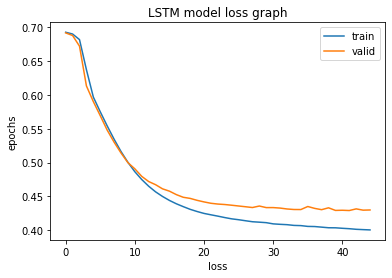

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("loss")
plt.ylabel("epochs")
plt.title("LSTM model loss graph")
plt.legend(["train", "valid"])
plt.show()

### 6. Using Dropouts for recurrent layer
- SimpleRNN, LSTM 클래스는 자체적으로 드롭아웃 기능을 제공하고 있음
- Using `dropout=_double`
- `recurrent_dropout=_double`
  - 단, 이 사용법은 은닉 상태에 드롭아웃 적용으로 GPU 사용이 불가함

In [ ]:
dropout_model = keras.Sequential([
    keras.layers.Embedding(500, 16, input_length=100),
    keras.layers.LSTM(8, dropout=0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


### 7. Training to LSTM model with Dropout
- RMSprop Optimizer 사용하는 대신 기존 LR 사용을 하지 않기 위해 별도 RMSprop 객체 생성
- Using **`keras.optimizers.RMSprop()`**
  - Using `learnig_rate=_1E`: 지수표기법 사용
- Using **`keras.callbacks.ModelCheckpoint()`**
- Using **`keras.callbacks.EarlyStopping()`**
- Using `history()`

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
dropout_model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_dropout_model = keras.callbacks.ModelCheckpoint("best-dropout-model.h5", save_best_only=True)
early_stopping_dropout_model = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = dropout_model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(valid_seq, valid_target),
    callbacks=[checkpoint_dropout_model, early_stopping_dropout_model]
    )

Epoch 1/100
313/313 [==============================] - 5s 10ms/step - loss: 0.6926 - accuracy: 0.5336 - val_loss: 0.6920 - val_accuracy: 0.5660
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6911 - accuracy: 0.5844 - val_loss: 0.6901 - val_accuracy: 0.6110
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6884 - accuracy: 0.6138 - val_loss: 0.6865 - val_accuracy: 0.6354
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6829 - accuracy: 0.6356 - val_loss: 0.6786 - val_accuracy: 0.6584
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6697 - accuracy: 0.6661 - val_loss: 0.6567 - val_accuracy: 0.6932
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6208 - accuracy: 0.7110 - val_loss: 0.5785 - val_accuracy: 0.7260
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5649 - accuracy: 0.7290 - val_loss: 0.5503 - val_accuracy: 0.748

### 8. Visualization LSTM model loss graph with Dropout


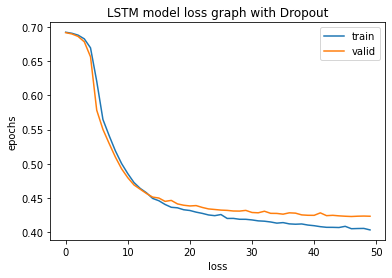

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("loss")
plt.ylabel("epochs")
plt.title("LSTM model loss graph with Dropout")
plt.legend(["train", "valid"])
plt.show()

> Best score 0.8175, Best loss 0.4032로 LSTM 모델보다 다소 성능이 떨어지는 것을 확인할 수 있음

### 9. Two recurrent layers Connect with recurrent neural network model
- **`return_sequences=_boolean`**: 순환 계층에서 모든 time-step의 은닉 상태를 출력


In [ ]:
nested_model = keras.Sequential([
    keras.layers.Embedding(500, 16, input_length=100),
    keras.layers.LSTM(8, dropout=0.3, return_sequences=True),
    keras.layers.LSTM(8, dropout=0.3),
    keras.layers.Dense(1, activation="sigmoid")
]) 

nested_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


> 첫 순환 계층의 출력은 (None, 100, 8)인데 모든 time-step의 은닉 상태를 출력하고 있고, 두번째 순환 계층은 (None, 8)이라 마지막 time-step의 은닉 상태 출력

### 10. Training to Two recurrent layers Connected RNN model
- RMSprop Optimizer 사용하는 대신 기존 LR 사용을 하지 않기 위해 별도 RMSprop 객체 생성
- Using **`keras.optimizers.RMSprop()`**
  - Using `learnig_rate=_1E`: 지수표기법 사용
- Using **`keras.callbacks.ModelCheckpoint()`**
- Using **`keras.callbacks.EarlyStopping()`**
- Using `history()`

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
nested_model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_nested_model = keras.callbacks.ModelCheckpoint("best-nested-model.h5", save_best_only=True)
early_stopping_nested_model = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = nested_model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(valid_seq, valid_target),
    callbacks=[checkpoint_nested_model, early_stopping_nested_model]
    )

Epoch 1/100
313/313 [==============================] - 8s 15ms/step - loss: 0.6925 - accuracy: 0.5537 - val_loss: 0.6913 - val_accuracy: 0.6166
Epoch 2/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6833 - accuracy: 0.6325 - val_loss: 0.6614 - val_accuracy: 0.6876
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6330 - accuracy: 0.6885 - val_loss: 0.6133 - val_accuracy: 0.7082
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6002 - accuracy: 0.7146 - val_loss: 0.5803 - val_accuracy: 0.7366
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 0.5659 - accuracy: 0.7373 - val_loss: 0.5448 - val_accuracy: 0.7524
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.5393 - accuracy: 0.7489 - val_loss: 0.5255 - val_accuracy: 0.7638
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 0.5226 - accuracy: 0.7599 - val_loss: 0.5104 - val_accuracy:

### 11. Visualization Two recurrent layers Connected RNN model loss graph

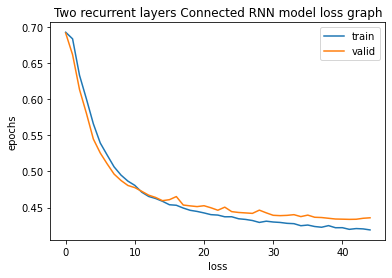

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("loss")
plt.ylabel("epochs")
plt.title("Two recurrent layers Connected RNN model loss graph")
plt.legend(["train", "valid"])
plt.show()

> Best score 0.8104, Best loss 0.4191로 LSTM 모델보다 다소 성능이 떨어지는 것을 확인할 수 있음

### 12. Create Gated Recurrent Unit Neural Network model
- Using **`keras.layers.GRU()`**

In [ ]:
gru_model = keras.Sequential([
  keras.layers.Embedding(500, 16, input_length=100),
  keras.layers.GRU(8),
  keras.layers.Dense(1, activation="sigmoid")     
])

gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


### 13. Training to GRU model
- RMSprop Optimizer 사용하는 대신 기존 LR 사용을 하지 않기 위해 별도 RMSprop 객체 생성
- Using **`keras.optimizers.RMSprop()`**
  - Using `learnig_rate=_1E`: 지수표기법 사용
- Using **`keras.callbacks.ModelCheckpoint()`**
- Using **`keras.callbacks.EarlyStopping()`**
- Using `history()`

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
gru_model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_gru_model = keras.callbacks.ModelCheckpoint("best-gru-model.h5", save_best_only=True)
early_stopping_gru_model = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = gru_model.fit(
    train_seq, train_target, epochs=100, batch_size=64,
    validation_data=(valid_seq, valid_target),
    callbacks=[checkpoint_gru_model, early_stopping_gru_model]
    )

Epoch 1/100
313/313 [==============================] - 5s 10ms/step - loss: 0.6918 - accuracy: 0.5410 - val_loss: 0.6903 - val_accuracy: 0.5750
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6881 - accuracy: 0.5880 - val_loss: 0.6861 - val_accuracy: 0.5920
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6815 - accuracy: 0.6206 - val_loss: 0.6781 - val_accuracy: 0.6182
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6695 - accuracy: 0.6429 - val_loss: 0.6630 - val_accuracy: 0.6394
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6469 - accuracy: 0.6646 - val_loss: 0.6339 - val_accuracy: 0.6752
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5982 - accuracy: 0.7007 - val_loss: 0.5671 - val_accuracy: 0.7202
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5295 - accuracy: 0.7444 - val_loss: 0.5215 - val_accuracy: 0.750

### 14. Visualization GRU model loss graph

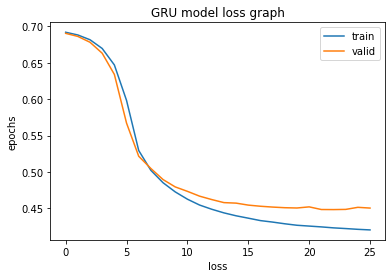

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("loss")
plt.ylabel("epochs")
plt.title("GRU model loss graph")
plt.legend(["train", "valid"])
plt.show()

> Best score 0.8142, Best loss 0.4204로 LSTM 모델보다 다소 성능이 떨어지는 것을 확인할 수 있음